Copyright 2022 The TensorFlow Similarity Authors.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Similarity ArcFace Loss Example

A Total Angular Margin Loss (ArcFace) calculates the geodetic distance in the hypersphere instead of the euclidean distance to improve the discriminatory strength of the facial recognition model and stabilize the training process. Rails are used to measure all distances in geodetic space. The geodetic trace is the path taken between two places. It specifies the geodetic distance, which is the shortest distance between two places.

ArcFace loss determines the angle between the current feature and the target weight using the arc-cosine function since the dot product between the DCNN feature and the last fully connected layer after feature and weight normalization matches the cosine distance. The target logit is then returned by multiplying the goal angle by an additional angular margin and using the cosine function. After that, we continue as before and rescale all logits to a certain feature norm, just like with softmax loss.

### Notebook goal

This notebook demonstrates how to use ArcFaceLoss implementation of TensorFlow Similarity with standalone usage and to train a `SimilarityModel()` on a fraction of the MNIST classes.

You are going to learn about the main features offered by the `ArcFaceLoss()` and will:

 1. Standalone usage of ArcFaceLoss

 2. Usage with `model.compile()`

 3. 3D-Visualization of ArcFaceLoss 

### Things to try 

Along the way you can try the following things to improve the model performance:
- Adding more "seen" classes at training time.
- Use a larger embedding by increasing the size of the output.
- Add data augmentation pre-processing layers to the model.
- Include more examples in the index to give the models more points to choose from.
- Try a more challenging dataset, such as Fashion MNIST.

### Notebook goal

This notebook demonstrates how to use ArcFaceLoss implementation of TensorFlow Similarity with standalone usage and to train a `SimilarityModel()` on a fraction of the MNIST classes.

You are going to learn about the main features offered by the `ArcFaceLoss()` and will:

 1. Standalone usage of ArcFaceLoss

 2. Usage with `model.compile()`

 3. 3D-Visualization of ArcFaceLoss 

### Things to try 

Along the way you can try the following things to improve the model performance:
- Adding more "seen" classes at training time.
- Use a larger embedding by increasing the size of the output.
- Add data augmentation pre-processing layers to the model.
- Include more examples in the index to give the models more points to choose from.
- Try a more challenging dataset, such as Fashion MNIST.

In [1]:
import gc
import os

import numpy as np
from matplotlib import pyplot as plt
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import tensorflow as tf

In [3]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [4]:
tfsim.utils.tf_cap_memory()

In [5]:
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [6]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.8.0
TensorFlow Similarity 0.17.0.dev10


# Standalone Usage of ArcFaceLoss

ArcFace loss alone can be used as follows when it is desired to calculate the additive angular margin loss of the existing data set.

### Initialize Loss function as ArcFaceLoss

In [7]:
loss_fn = tfsim.losses.ArcFaceLoss(num_classes=8, embedding_size=10)

### Create own simple random dataset

In [8]:
labels = tf.Variable([0, 1, 2, 3, 4, 5, 6, 7])
embeddings = tf.Variable(tf.random.uniform(shape=[8, 10]))

In [9]:
print("", embeddings)

 <tf.Variable 'Variable:0' shape=(8, 10) dtype=float32, numpy=
array([[0.19907904, 0.07729328, 0.1722784 , 0.3601575 , 0.8714011 ,
        0.01628113, 0.88918483, 0.11690199, 0.89015555, 0.955421  ],
       [0.10166383, 0.15534246, 0.32394028, 0.04517233, 0.9408107 ,
        0.11309135, 0.6513635 , 0.62346923, 0.53416014, 0.07642305],
       [0.17923808, 0.2462269 , 0.88302803, 0.73461497, 0.16814685,
        0.90763843, 0.37768447, 0.9759656 , 0.07663143, 0.9839252 ],
       [0.68011904, 0.47713315, 0.83367133, 0.68903136, 0.928967  ,
        0.9224856 , 0.9985844 , 0.6639615 , 0.16083932, 0.90435326],
       [0.9497577 , 0.3427589 , 0.57741416, 0.3175465 , 0.51394975,
        0.7281352 , 0.9438957 , 0.9242332 , 0.02530515, 0.09110975],
       [0.91824436, 0.6679524 , 0.6155938 , 0.92593694, 0.10095346,
        0.52267945, 0.9936875 , 0.03321242, 0.4724722 , 0.02045906],
       [0.5431701 , 0.5046103 , 0.79197395, 0.8770155 , 0.6117593 ,
        0.21793449, 0.07952356, 0.11457705, 0.7

### Calculate loss

In [10]:
loss = loss_fn(labels, embeddings)

In [11]:
print("loss : " , loss)

loss :  tf.Tensor(48.764076, shape=(), dtype=float32)


## Data preparation

We are going to load the MNIST dataset to showcase how the model is able to find similar examples from classes unseen during training. The model's ability to generalize the matching to unseen classes, without retraining, is one of the main reason you would want to use metric learning.


**WARNING**: Tensorflow similarity expects `y_train` to be an IntTensor containing the class ids for each example instead of the standard categorical encoding traditionally used for multi-class classification.

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Model setup

### Model definition

`SimilarityModel()` models extend `tensorflow.keras.model.Model` with additional features and functionality that allow you to index and search for similar looking examples.

As visible in the model definition below, similarity models output a 64 dimensional float embedding using the `MetricEmbedding()` layers. This layer is a Dense layer with L2 normalization. Thanks to the loss, the model learns to minimize the distance between similar examples and maximize the distance between dissimilar examples. As a result, the distance between examples in the embedding space is meaningful; the smaller the distance the more similar the examples are. 

Being able to use a distance as a meaningful proxy for how similar two examples are, is what enables the fast ANN (aproximate nearest neighbor) search. Using a sub-linear ANN search instead of a standard quadratic NN search is what allows deep similarity search to scale to millions of items. The built in memory index used in this notebook scales to a million indexed examples very easily... if you have enough RAM :)

In [16]:
def get_model():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255)(inputs)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    # smaller embeddings will have faster lookup times while a larger embedding will improve the accuracy up to a point.
    outputs = tfsim.layers.MetricEmbedding(64)(x)
    return tfsim.models.SimilarityModel(inputs, outputs)

In [17]:
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                  

### ArcFace Loss definition

Overall what makes Metric losses different from tradional losses is that:
- **They expect different inputs.** Instead of having the prediction equal the true values, they expect embeddings as `y_preds` and the id (as an int32) of the class as `y_true`. 
- **They require a distance.** You need to specify which `distance` function to use to compute the distance between embeddings. `cosine` is usually a great starting point and the default.

ArcFace Loss takes inputs as number of classes which labels includes, and embedding size which we define in model `MetricEmbedding()` layers.

In [18]:
distance = "cosine" 

In [19]:
num_classes = np.unique(y_train).size
embedding_size = model.get_layer('metric_embedding').output.shape[1]

In [20]:
loss = tfsim.losses.ArcFaceLoss(num_classes=num_classes, embedding_size=embedding_size, name="ArcFaceLoss")

### Compilation

Tensorflow similarity use an extended `compile()` method that allows you to optionally specify `distance_metrics` (metrics that are computed over the distance between the embeddings), and the distance to use for the indexer.

By default the `compile()` method tries to infer what type of distance you are using by looking at the first loss specified. If you use multiple losses, and the distance loss is not the first one, then you need to specify the distance function used as `distance=` parameter in the compile function.

In [21]:
LR = 0.0005  # @param {type:"number"}
model.compile(optimizer=tf.keras.optimizers.SGD(LR), loss=loss, distance=distance)

## Training

Similarity models are trained like normal models. 

In [22]:
EPOCHS = 10  # @param {type:"integer"}
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 11s 4ms/step - loss: 5.2161 - val_loss: 1.8907
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.8353 - val_loss: 1.6826
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.3566 - val_loss: 1.1404
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.1160 - val_loss: 1.0936
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.9555 - val_loss: 1.0854
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.8343 - val_loss: 1.0062
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7546 - val_loss: 0.9062
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6776 - val_loss: 0.8000
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6194 - val_loss: 0.8160
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.56

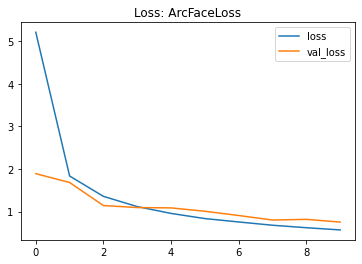

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name}")
plt.show()

## Prediction

Let's predict some features and visualize them.

In [28]:
embedded_features = model.predict(x_test, verbose=1)

313/313 [==============================] - 1s 2ms/step


### 3D-Visualization of ArcFace Loss

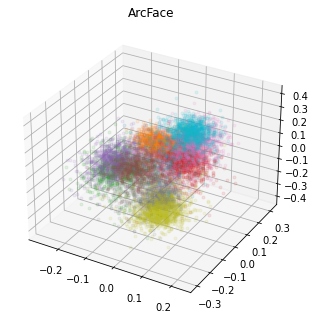

In [38]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
for c in range(len(np.unique(y_test))):
    ax.plot(
        embedded_features[y_test==c, 0], 
        embedded_features[y_test==c, 1], 
        embedded_features[y_test==c, 2], 
        '.', 
        alpha=0.1,
    )
plt.title('ArcFace')
plt.show()